In [1]:
import pandas as pd
import numpy as np
from anndata import AnnData
import scanpy as sc
import scipy.sparse as sp
from tqdm import tqdm
from paste import pairwise_align
import ot
import torch
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

In [2]:
dataset_HVG_path = '/home/hanyuji/Workbench/ST/ST_data_check/paste_alignment_cortex/PASTE_align/cortex_macaque1_119slice_subset_12000spot_2000gene_HVG.h5ad'

adata = sc.read_h5ad(dataset_HVG_path)

In [3]:
def random_subset(adata, cell_num=5000):
    '''随机选取 5000 个细胞'''
    
    random_indices = np.random.choice(adata.n_obs, cell_num, replace=False)  # 从 276593 个细胞中随机选取 3000 个细胞的索引
    adata_subset = adata[random_indices, :]  # 使用选取的索引创建新的 AnnData 对象

    return adata_subset


# 根据batch值分开成多个AnnData对象
unique_batches = adata.obs['batch'].unique()
adata_list = [random_subset(adata[adata.obs['batch'] == batch].copy()) for batch in unique_batches]
# adata_list = [adata[adata.obs['batch'] == batch].copy() for batch in unique_batches]

In [4]:
def get_edge_index(M):
    # 将稠密矩阵M转换为稀疏矩阵，并获得边的索引edge_index 
    M_ = coo_matrix(M) # 稠密矩阵--->稀疏矩阵
    values = M_.data
    indices = np.vstack((M_.row, M_.col))  # 我们真正需要的coo形式
    return indices

In [6]:
torch.cuda.set_device(0)  # 将设备设置为 'cuda:0'

all_pairwise_index = []
# for i in tqdm(range(len(adata_list)-1)):
for i in tqdm(range(7)):

    pi = pairwise_align(sliceA=adata_list[i],sliceB=adata_list[i+1], backend = ot.backend.TorchBackend(), use_gpu = True, numItermax=50000)
    edge_index = get_edge_index(pi)
    all_pairwise_index.append(edge_index)

  0%|          | 0/7 [00:00<?, ?it/s]

gpu is available, using gpu.


/home/hanyuji/miniconda3/envs/PASTE/lib/python3.9/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
 14%|█▍        | 1/7 [00:35<03:32, 35.36s/it]

gpu is available, using gpu.


/home/hanyuji/miniconda3/envs/PASTE/lib/python3.9/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
 29%|██▊       | 2/7 [01:22<03:31, 42.34s/it]

gpu is available, using gpu.


/home/hanyuji/miniconda3/envs/PASTE/lib/python3.9/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
 43%|████▎     | 3/7 [01:53<02:27, 36.96s/it]

gpu is available, using gpu.


/home/hanyuji/miniconda3/envs/PASTE/lib/python3.9/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
 57%|█████▋    | 4/7 [02:17<01:36, 32.09s/it]

gpu is available, using gpu.


/home/hanyuji/miniconda3/envs/PASTE/lib/python3.9/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
 71%|███████▏  | 5/7 [02:48<01:02, 31.46s/it]

gpu is available, using gpu.


/home/hanyuji/miniconda3/envs/PASTE/lib/python3.9/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
 86%|████████▌ | 6/7 [03:24<00:33, 33.03s/it]

gpu is available, using gpu.


/home/hanyuji/miniconda3/envs/PASTE/lib/python3.9/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
100%|██████████| 7/7 [03:59<00:00, 34.16s/it]


In [7]:
all_pairwise_index

[array([[   0,    1,    2, ..., 4997, 4998, 4999],
        [1889, 2930, 3046, ...,   16, 3770, 1321]], dtype=int32),
 array([[   0,    1,    2, ..., 4997, 4998, 4999],
        [1568, 4102,  293, ..., 1785, 2758, 4379]], dtype=int32),
 array([[   0,    1,    2, ..., 4997, 4998, 4999],
        [4327, 4278, 2207, ...,  989,  627, 4832]], dtype=int32),
 array([[   0,    1,    2, ..., 4997, 4998, 4999],
        [1263,  971, 1284, ..., 2181, 1463, 4967]], dtype=int32),
 array([[   0,    1,    2, ..., 4997, 4998, 4999],
        [4644, 4227, 2537, ..., 4757, 2121, 3291]], dtype=int32),
 array([[   0,    1,    2, ..., 4997, 4998, 4999],
        [3182, 4390, 1185, ...,  261, 2515, 4944]], dtype=int32),
 array([[   0,    1,    2, ..., 4997, 4998, 4999],
        [4600, 1995, 4713, ..., 1733, 2265, 4838]], dtype=int32)]

In [34]:
def track_sequence(start, arrays):
    # start是起始数字，arrays是数组列表
    path = [start]  # 轨迹起始
    current = start
    for arr in arrays:
        idx = np.where(arr[0] == current)[0][0]  # 找到current在第一维的位置
        current = arr[1][idx]  # 获取该位置在第二维的对应数字
        path.append(current)  # 添加到路径中
    return path


# 跟踪所有起始数字的轨迹
paths = np.array([track_sequence(i, all_pairwise_index) for i in range(5000)])


In [37]:
paths[42]

array([  42, 2140,  736, 2758,  910, 3238, 2542, 4966])

# 保存结果

In [ ]:
import pickle

# 定义变量
a = {'name': 'Alice', 'age': 25}

'''保存变量'''
with open('variable_a.pkl', 'wb') as file:
    pickle.dump(a, file)


'''加载变量'''
with open('variable_a.pkl', 'rb') as file:
    loaded_a = pickle.load(file)


# 可视化

In [ ]:
slice_0 = adata_list[106]
slice_1 = adata_list[107]

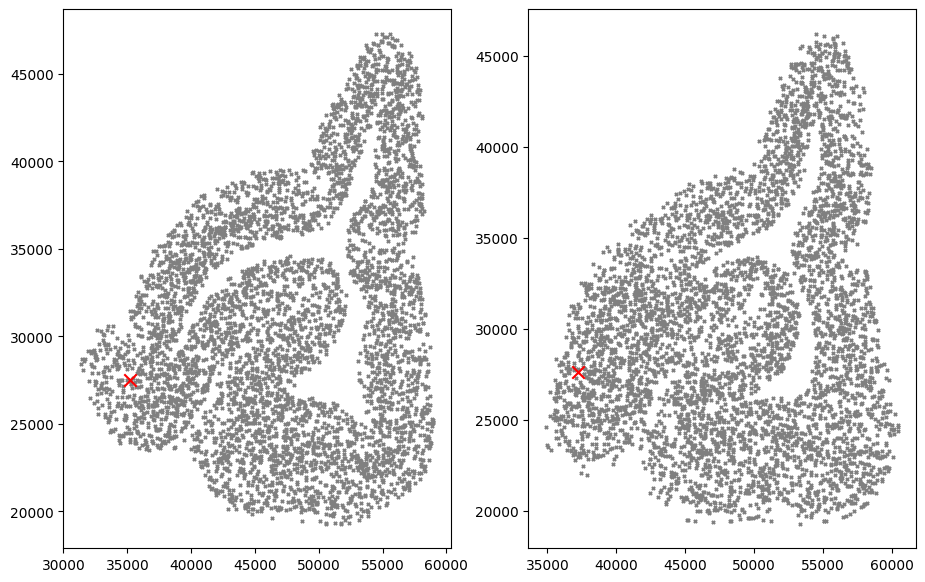

In [12]:
def plt_aligned_point(choiced_index):
    '''
    随机选取两个对齐的spot
    展示两个点的坐标
    持续1s
    '''
    coo_all_0 = slice_0.obsm['spatial']
    coo_all_1 = slice_1.obsm['spatial']

    aligned_point_0 = coo_all_0[edge_index[0,choiced_index]]
    aligned_point_1 = coo_all_1[edge_index[1,choiced_index]]

    fig, axs = plt.subplots(1, 2, figsize=(11, 7))
    # 背景
    axs[0].scatter(coo_all_0[:, 0], coo_all_0[:, 1], c='gray', marker='x',s=5)
    axs[1].scatter(coo_all_1[:, 0], coo_all_1[:, 1], c='gray', marker='x',s=5)
    # 对齐的两个点
    axs[0].scatter(aligned_point_0[0], aligned_point_0[1], c='r', marker='x',s=80)
    axs[1].scatter(aligned_point_1[0], aligned_point_1[1], c='r', marker='x',s=80)    

    plt.show()
    # display(plt.gcf())
    time.sleep(1)  # 等待1秒钟
    clear_output(wait=True)


import time
from IPython.display import clear_output, display

for i in range(15):
    choiced_index = np.random.randint(3000)
    plt_aligned_point(choiced_index)


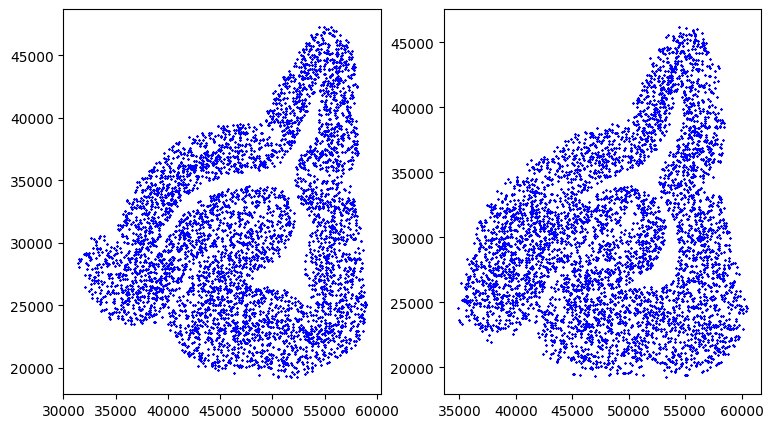

In [22]:
import matplotlib.pyplot as plt

s0_1 = [slice_0,slice_1]
fig, axs = plt.subplots(1, 2, figsize=(9, 5))

for i, ax in enumerate(axs.flat):
    coo = pd.DataFrame(s0_1[i].obsm['spatial'])
    ax.scatter(coo[0], coo[1], c='b', marker='x',s=1)

plt.show()